# User Engagement and Emotional Communication Analysis

This NOTEBOOK accomplishes the following tasks:
1. user stratification analysis based on number of likes
2. Sentiment quality of highly popular tweets vs. regular tweets
3. Sentiment spreading analysis of core users vs. peripheral users

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

sns.set_theme(style="whitegrid")  

In [4]:

df = pd.read_csv("../2_data/finbert_scored_tweets.csv", parse_dates=["created_at"])

# deal with likes
def extract_likes(likes_dict):
    if pd.isna(likes_dict):
        return 0
    try:
        if isinstance(likes_dict, str):
            import ast
            likes_dict = ast.literal_eval(likes_dict)
        return likes_dict.get('total', 0)
    except:
        return 0

df['likes'] = df['likes'].apply(extract_likes)

# deal with username
def extract_username(user_dict):
    if pd.isna(user_dict):
        return 'unknown'
    try:
        if isinstance(user_dict, str):
            import ast
            user_dict = ast.literal_eval(user_dict)
        return user_dict.get('username', 'unknown')
    except:
        return 'unknown'

df['username'] = df['user'].apply(extract_username)

print(f"Total tweets: {len(df)}")
print(f"Total users: {df['username'].nunique()}")
print(f"Total likes: {df['likes'].sum()}")

总推文数: 513285
总用户数: 43585
总点赞数: 717597



## 2. Stratification of users based on number of likes

用户分层统计:
           username  total_likes  avg_sentiment  tweet_count
user_type                                                   
普通用户          41402         6.31           0.14         5.26
高人气用户          2183       209.05           0.13       135.44


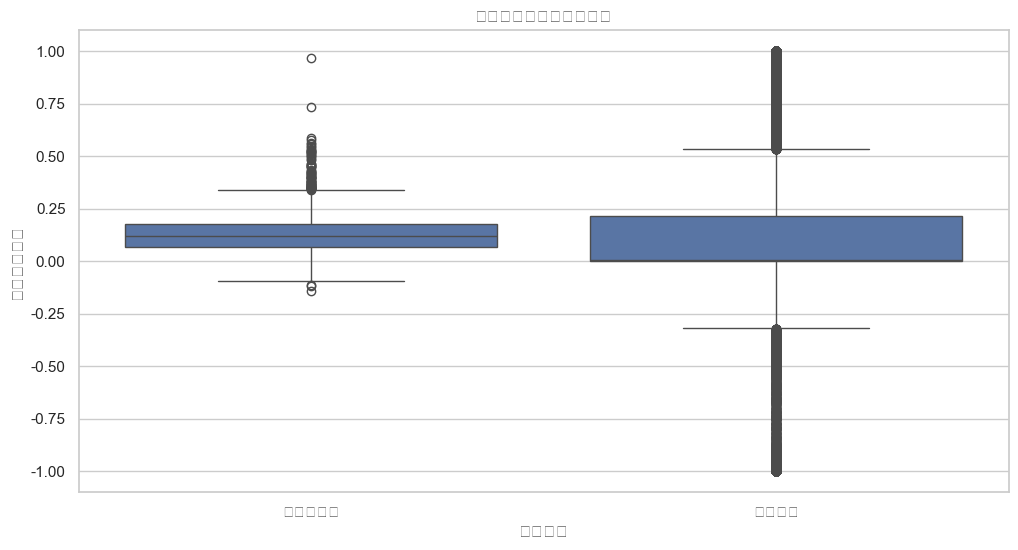

In [5]:
# calculate the total likes and average sentiment for each user
user_engagement = df.groupby('username').agg({
    'likes': 'sum',
    'finbert_score': ['mean', 'std', 'count']
}).reset_index()

user_engagement.columns = ['username', 'total_likes', 'avg_sentiment', 'sentiment_std', 'tweet_count']

# define the user stratification standard
like_threshold = user_engagement['total_likes'].quantile(0.95)  # top 5% users
user_engagement['user_type'] = np.where(user_engagement['total_likes'] >= like_threshold, 'High-engagement users', 'Regular users')

# show the user stratification statistics
print("User stratification statistics:")
print(user_engagement.groupby('user_type').agg({
    'username': 'count',
    'total_likes': 'mean',
    'avg_sentiment': 'mean',
    'tweet_count': 'mean'
}).round(2))

# visualize the user stratification
plt.figure(figsize=(12, 6))
sns.boxplot(x='user_type', y='avg_sentiment', data=user_engagement)
plt.title('Different user types sentiment distribution')
plt.xlabel('User type')
plt.ylabel('Average sentiment score')
plt.show()

## 3. Sentiment quality of highly popular tweets vs. regular tweets

推文情感统计:
           finbert_score                             likes
                   count    mean     std  min  max    mean
tweet_type                                                
普通推文              477615  0.1209  0.4193 -1.0  1.0  0.9223
高人气推文              35670  0.1542  0.4051 -1.0  1.0  7.7684


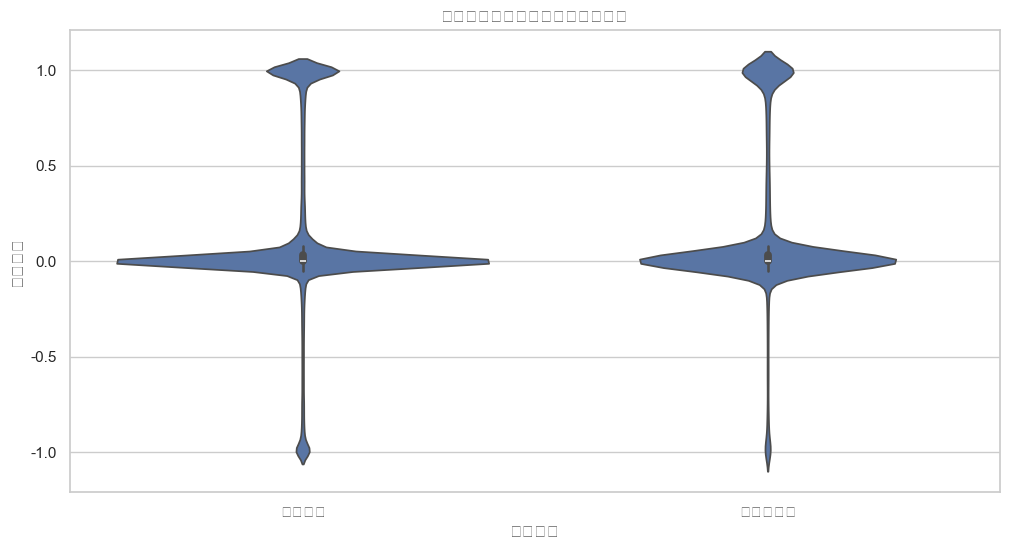

In [6]:
# Define the standard for highly popular tweets
tweet_like_threshold = df['likes'].quantile(0.95)  # top 5% tweets
df['tweet_type'] = np.where(df['likes'] >= tweet_like_threshold, 'High-engagement tweets', 'Regular tweets')

# calculate the sentiment statistics
tweet_sentiment_stats = df.groupby('tweet_type').agg({
    'finbert_score': ['count', 'mean', 'std', 'min', 'max'],
    'likes': 'mean'
}).round(4)

print("Tweet sentiment statistics:")
print(tweet_sentiment_stats)

# visualize the sentiment distribution
plt.figure(figsize=(12, 6))
sns.violinplot(x='tweet_type', y='finbert_score', data=df)
plt.title('Sentiment distribution of highly popular tweets vs. regular tweets')
plt.xlabel('Tweet type')
plt.ylabel('Sentiment score')
plt.show()


## 4. Emotional communication network analysis

In [ ]:
# Create the interaction network
def create_interaction_network(df, time_window=timedelta(hours=24)):
    G = nx.DiGraph()
    
    # sort by time
    df = df.sort_values('created_at')
    
    # create user nodes
    for username in df['username'].unique():
        user_sentiment = df[df['username'] == username]['finbert_score'].mean()
        G.add_node(username, sentiment=user_sentiment)
    
    # create edges (user interactions)
    for i, row in df.iterrows():
        current_time = row['created_at']
        window_start = current_time - time_window
        
        # find the tweets within the time window
        window_tweets = df[(df['created_at'] >= window_start) & 
                          (df['created_at'] <= current_time)]
        
        # add edges
        for _, other_row in window_tweets.iterrows():
            if row['username'] != other_row['username']:
                G.add_edge(other_row['username'], row['username'])
    
    return G

# Create the network
G = create_interaction_network(df)

# calculate the network metrics
print("Network statistics:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# identify the core users (using the PageRank algorithm)
pagerank = nx.pagerank(G)
core_users = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:10]

print("\nCore users (PageRank ranking top 10):")
for user, score in core_users:
    print(f"{user}: {score:.4f}")

# visualize the network
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G, k=1, iterations=50)

# draw the nodes
node_colors = [G.nodes[node]['sentiment'] for node in G.nodes()]
node_sizes = [pagerank[node] * 10000 for node in G.nodes()]

nx.draw_networkx_nodes(G, pos, 
                      node_color=node_colors,
                      node_size=node_sizes,
                      cmap='RdYlBu',
                      alpha=0.6)

# draw the edges
nx.draw_networkx_edges(G, pos, alpha=0.2)

# add the core users labels
core_user_labels = {user: user for user, _ in core_users}
nx.draw_networkx_labels(G, pos, labels=core_user_labels)

plt.title('User emotional communication network\n(node size represents influence, color represents sentiment倾向)')
plt.colorbar(plt.cm.ScalarMappable(cmap='RdYlBu'), label='Sentiment score')
plt.axis('off')
plt.show()

In [ ]:
# Store the analysis results
user_engagement.to_csv("../2_data/user_engagement_analysis.csv", index=False)

# Save the tweet classification results
df[['username', 'created_at', 'likes', 'finbert_score', 'tweet_type']].to_csv("../2_data/tweet_engagement_analysis.csv", index=False)

print("Analysis results saved to files")